In [1]:
from perfect_maximum_likelihood_decoder import PMLD
import jax.numpy as jnp

In [7]:
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

from packages.quantum_error_correction import *
from jax import vmap

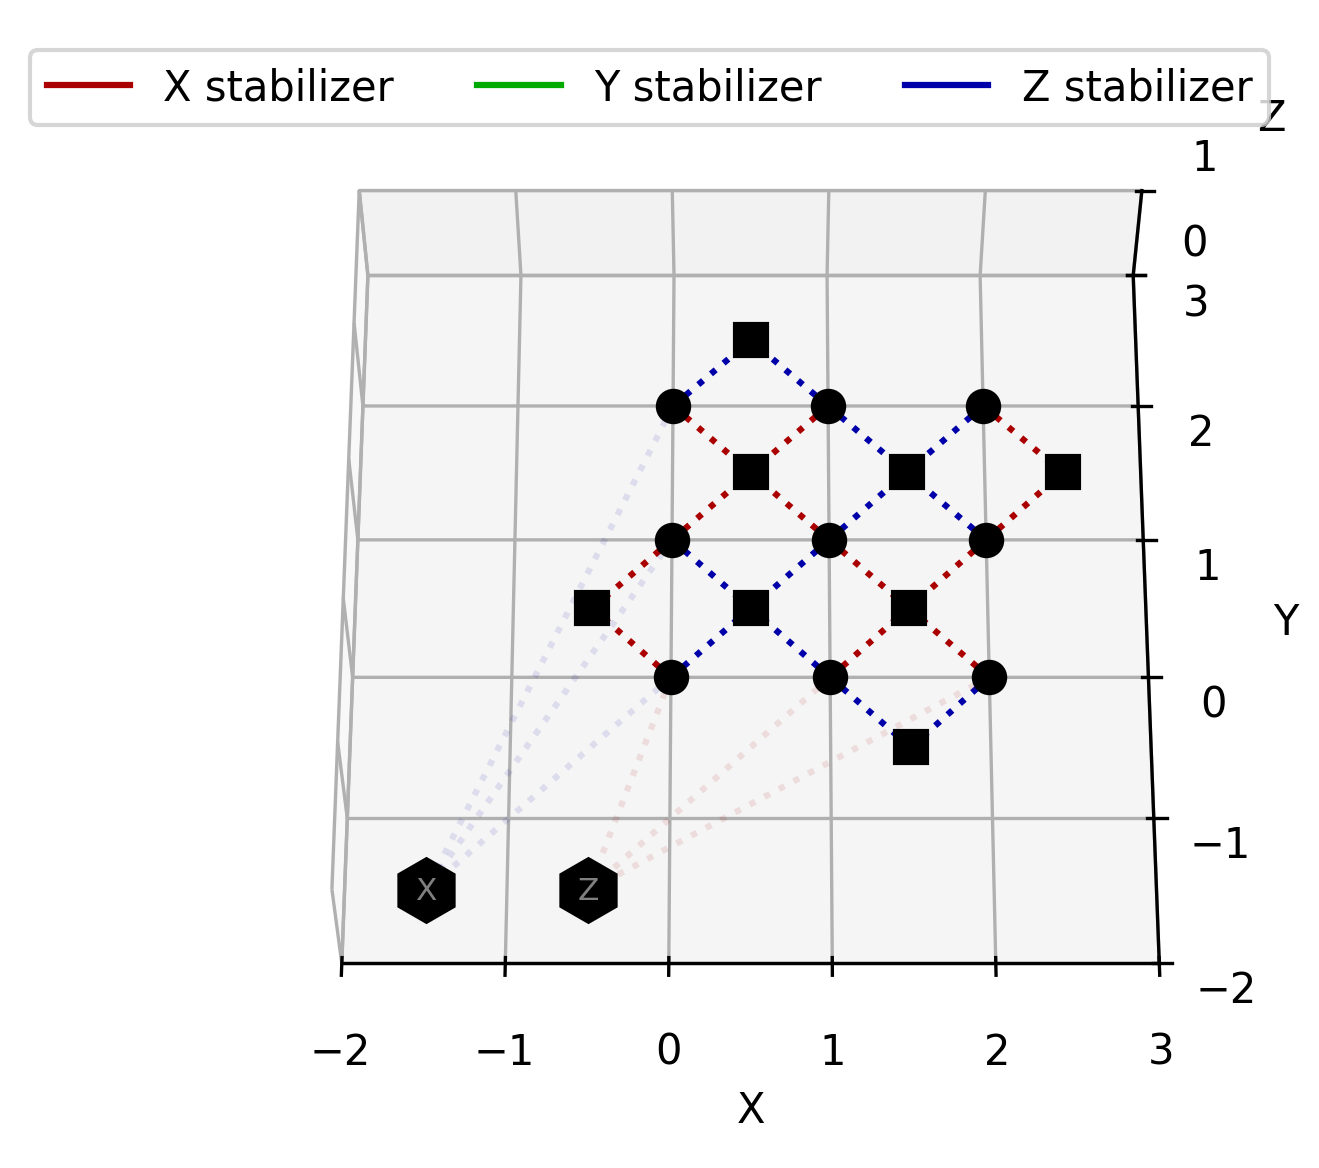

In [4]:
code_distance = 3

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
Hx, Hy, Hz = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
H_syndrome={'x': Hx[:-2], 'y': Hy[:-2], 'z': Hz[:-2]}
H_logicals={'x': Hx[-2:], 'y': Hy[-2:], 'z': Hz[-2:]}
nsq, ndq = H_syndrome['x'].shape
qec.show();

In [5]:
H_syndrome = {
    'x': jnp.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 
    'y': jnp.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]]), 
    'z': jnp.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]])
}
H_logicals = {
    'x': jnp.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 
    'y': jnp.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0]]), 
    'z': jnp.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0]])}
perfect_decoder = PMLD(H_syndrome, H_logicals)

# Noise model
p_tot = .01
nu = 500
error_prob = [
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
]
print(error_prob)
physical_error_rates = jnp.array([1-sum(error_prob), *error_prob])
noise_model=jnp.ones(shape=(9,4))*physical_error_rates

[9.98003992015968e-06, 9.98003992015968e-06, 0.00998003992015968]


In [6]:
used_deformations = jnp.array([0,2,3])
all_deformation_idx = jnp.zeros(shape=(used_deformations.shape[0]**9,9), dtype=jnp.int32) + jnp.arange(0,used_deformations.shape[0]**9)[:, None]
all_deformations = (all_deformation_idx // used_deformations.shape[0]**jnp.arange(0,9)) % used_deformations.shape[0]
all_deformations = used_deformations[all_deformations]
all_deformations

Array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 3, ..., 3, 3, 3],
       [2, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int32)

In [8]:
from time import time
t0 = time()

p_tot = .01
nu = 500
error_prob = [
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
]
print(error_prob)
physical_error_rates = jnp.array([1-sum(error_prob), *error_prob])
error_probs=jnp.ones(shape=(9,4))*physical_error_rates
logical_error_rates_batch = vmap(
    perfect_decoder.logical_error_rate,
    in_axes=[None, 0],
    out_axes=0
)
all_logical_error_rates = jnp.zeros(shape=[all_deformations.shape[0], 4])
batch_size = 81
for i, deformations_batch in enumerate(all_deformations.reshape((all_deformations.shape[0] // batch_size, batch_size, 9))):
    all_logical_error_rates = all_logical_error_rates.at[i*batch_size:(i+1)*batch_size].set(
        logical_error_rates_batch(error_probs, deformations_batch)
    )
    procentage = (i+1) / (all_deformations.shape[0] // batch_size)
    remaining_time = (time()-t0) / procentage * (1 - procentage)
    print(f"{int(remaining_time/60/60):5d}h {int(remaining_time/60%60):02d}m {int(remaining_time%60):02d}s", end='\r')

[9.98003992015968e-06, 9.98003992015968e-06, 0.00998003992015968]


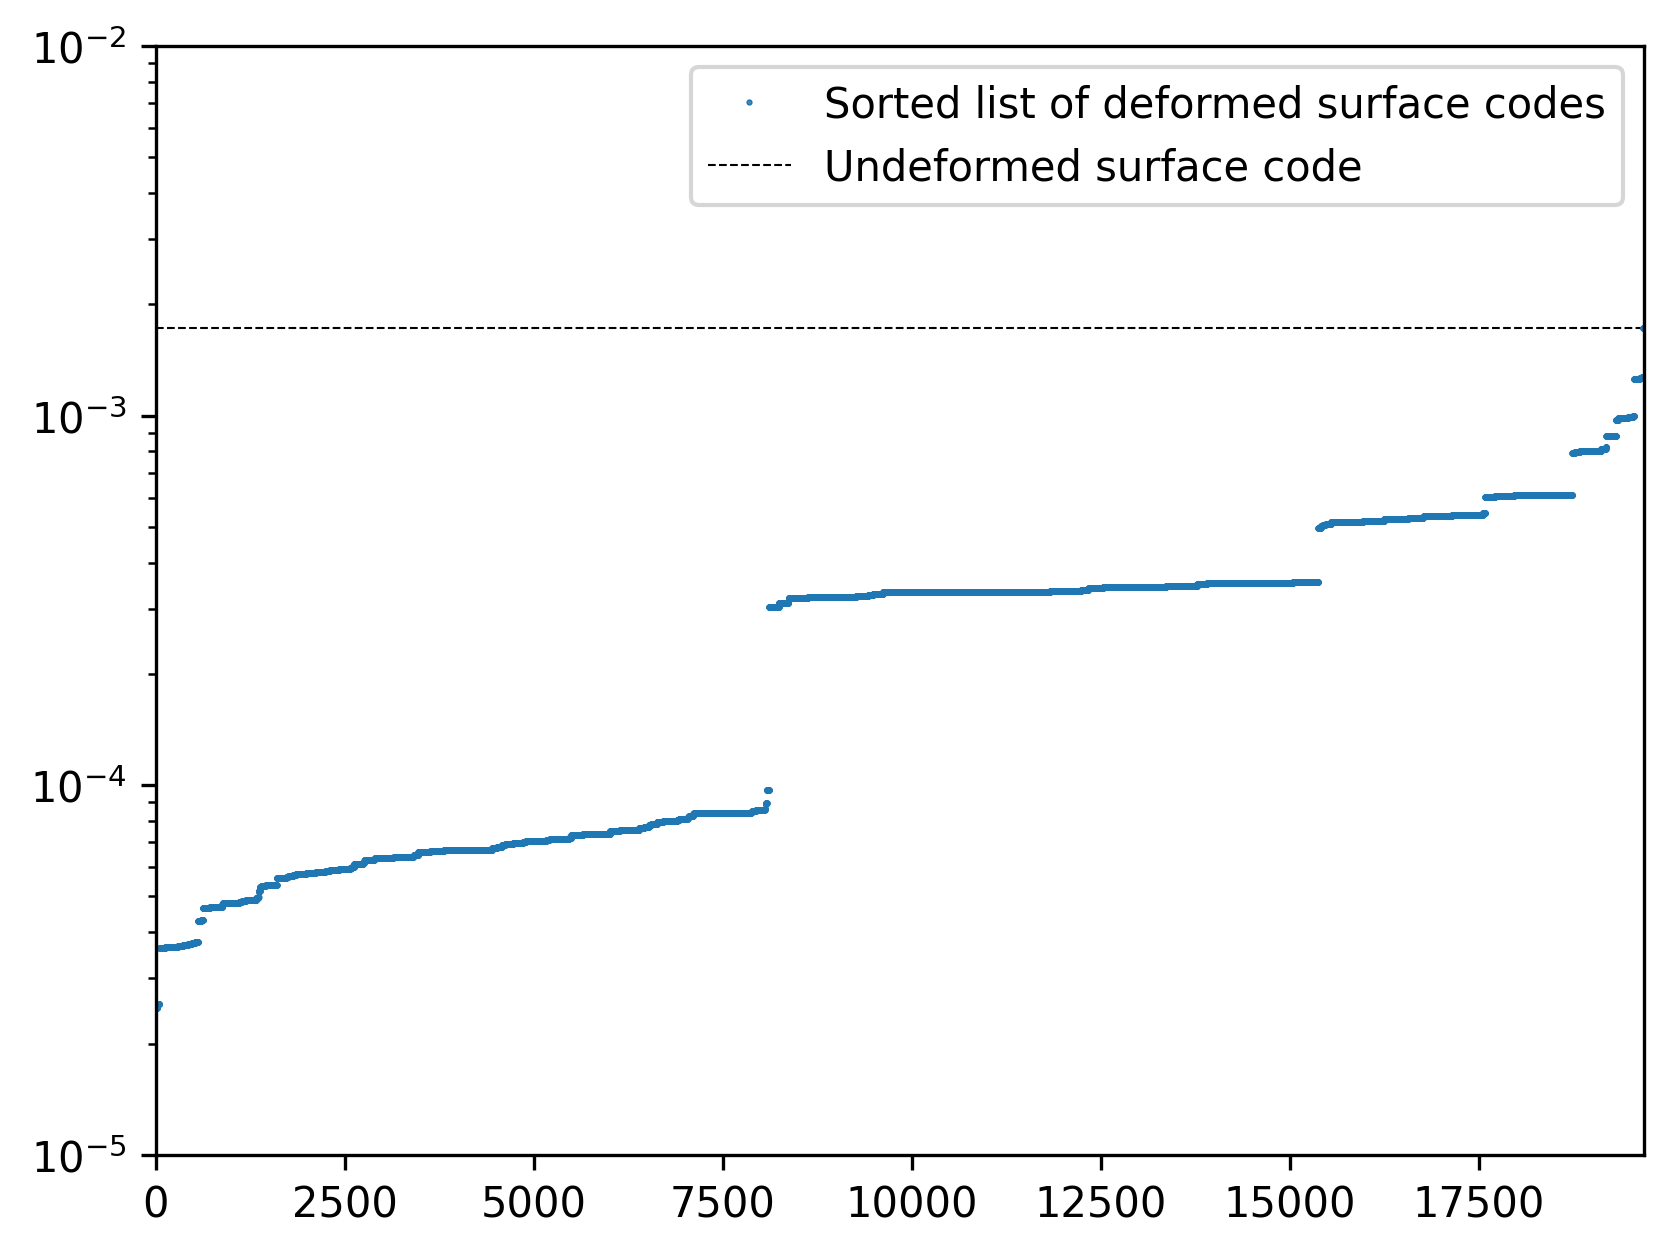

In [15]:
total_logical_error_rate = 1-all_logical_error_rates[:,0]
sorted_idx = total_logical_error_rate.argsort()
plt.figure(dpi=300)
plt.plot(
    jnp.arange(0, sorted_idx.shape[0]), 
    total_logical_error_rate[sorted_idx],
    '.', ms=1,
    label='Sorted list of deformed surface codes'
)
plt.hlines([total_logical_error_rate[0]], [0], [total_logical_error_rate.shape[0]], color='k', ls='--', lw=.5, zorder=-1, label='Undeformed surface code')
plt.legend()
plt.yscale('log')
plt.ylim(1E-5, 1E-2)
plt.xlim(0, total_logical_error_rate.shape[0])
plt.show()

In [16]:
from matplotlib.colors import ListedColormap
deformation_cmap = ListedColormap([
    "#FFFFFF", # I
    "#88C946", # X-Y
    "#C43119", # Y-Z
    "#00ADE7", # X-Z
    "#833794", # X-Y-Z
    "#FFB94C", # X-Z-Y
])

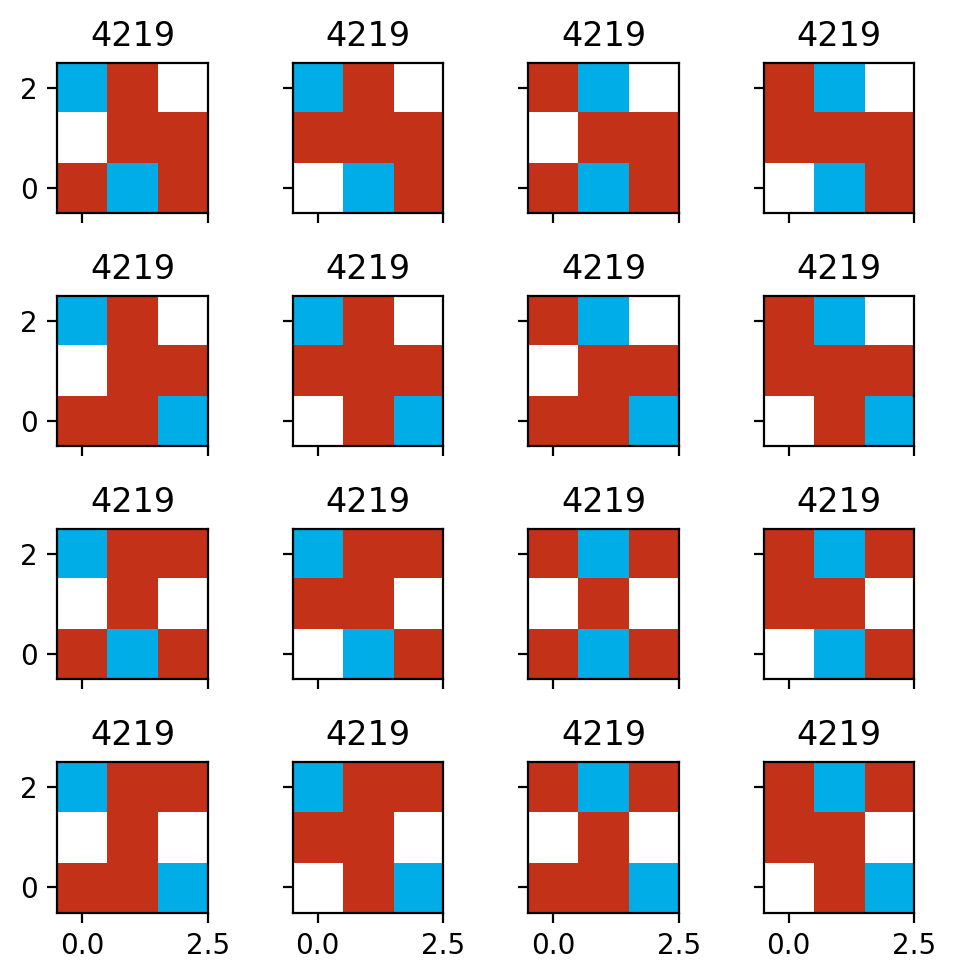

In [17]:
fig, ax = plt.subplots(4,4, sharex=True, sharey=True, dpi=200)
fig.set_figwidth(5)
fig.set_figheight(5)
for i, idx_row in enumerate(jnp.where(total_logical_error_rate < 2.5E-5)[0].reshape(4,4)):
    for j, idx in enumerate(idx_row):
        ax[i][j].set_title(f"{-jnp.log(.9)/total_logical_error_rate[idx]:.0f}")
        ax[i][j].imshow(all_deformations[idx].reshape((3,3)).T, origin='lower', vmin=0, vmax=5, cmap=deformation_cmap)
plt.tight_layout()

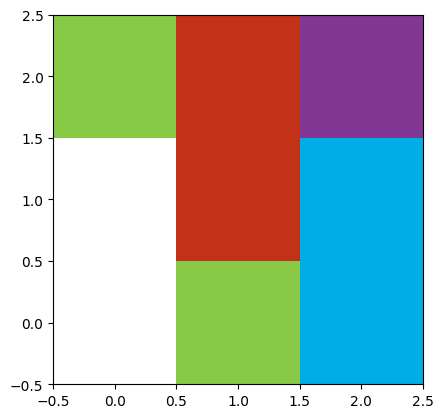

In [20]:
plt.imshow(jnp.array([0,0,1,1,2,2,3,3,4]).reshape((3,3)).T, origin='lower', vmin=0, vmax=5, cmap=deformation_cmap)